In [ ]:
# from extract_face import img
from config import get_config
from glob import glob
from utils import get_pairs_intra_label, get_pairs_inter_label, findDistance_cos, findDistance, calc_diff_and_similar
from Learner import face_learner
# print(findDistance(np.array([2, 2]), np.array([1, 1])))

conf = get_config(False)
list_label_folder = glob(f"{conf.infer_dataset}/*")


all_intra_pairs, all_inter_pairs = [], []

for path in list_label_folder[:10]:
    intra_pairs = get_pairs_intra_label(path)
    all_intra_pairs += intra_pairs
    all_inter_pairs += get_pairs_inter_label(path, list_label_folder, intra_pairs)

learner = face_learner(conf, True)
learner.threshold = 1.54
if conf.device.type == 'cpu':
    learner.load_state(conf, 'cpu_final.pth', True, True)
else:
    learner.load_state(conf, 'final.pth', True, True)
learner.model.eval()
print('learner loaded')


diff1, similar1 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance)
diff2, similar2 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance_cos)


  0%|          | 0/11 [00:00<?, ?it/s]

ir_se_50 model generated
learner loaded


 45%|████▌     | 5/11 [00:06<00:07,  1.32s/it]

In [11]:
import seaborn as sns

sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

In [3]:
import seaborn as sns

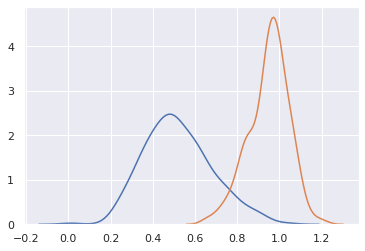

In [9]:
sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

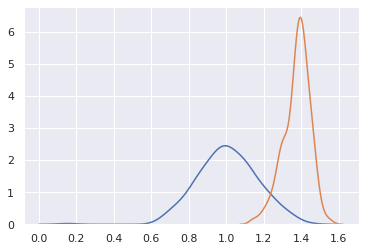

In [12]:
sns.set(color_codes=True)
sns.distplot(similar2, hist=False)
sns.distplot(diff2, hist=False)